<a href="https://colab.research.google.com/github/cwerries/IANNWTF_Group_14_Submissions/blob/master/LSTM_hanna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras import activations, initializers, regularizers
import numpy as np
import matplotlib.pyplot as plt

# Creating the data set

In [2]:
def integration_task(seq_len, num_samples):
    # This function should for num samples times yield a random noise signal of the size seq_len 
    # sequence length = number of time steps we are considering
    for sample in range(num_samples):
      n = np.random.normal(size = seq_len)
      yield np.expand_dims(n, -1), np.expand_dims(int(np.sum(n) > 1), -1)


# wrapper generator
def my_integration_task():
  seq_len = 25
  num_samples = 80000
  #  iterating through integration task with specified seq len and num samples - yielding functions yield
  for gen in integration_task(seq_len, num_samples):
    yield gen

##Prepare Dataset

In [3]:
def prepare_data(ds):
  #shuffle, batch, prefetch
  ds = ds.shuffle(1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(300)
  return ds

# Train and Test functions

In [4]:
#Description: This function trains an object of the class MyModel. It conducts a forward-step and the backpropagation 
#             throughout the network. The optimizer updates weights and biases. 
#             Inputs: model, inputs, target, loss function, optimizer
#             Outputs:loss, accuracy
def train_step(model, inputs, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
      prediction = model(inputs)[-1]
      loss = loss_function(target, prediction)
      sample_train_accuracy =  target == np.round(prediction)
      sample_train_accuracy = np.mean(sample_train_accuracy)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, sample_train_accuracy

#Description: This function determines the test loss and test accuracy through a forward step in the network.
#             Inputs: model, test data, loss function
#             Outputs: test loss, test accuracy
def test(model, test_data, loss_function):
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
      prediction = model(input)[-1]       
      sample_test_loss = loss_function(target, prediction)
      sample_test_accuracy =  target == np.round(prediction)
      sample_test_accuracy = np.mean(sample_test_accuracy)
      test_loss_aggregator.append(sample_test_loss.numpy())
      test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

# The network

##Cell

In [5]:
# Implement a LSTM_cell
# input for a single times step and a tuple containing (hidden state, cell state) # input, (hidden_state, cell_state)
class LSTM_cell(tf.keras.layers.Layer):

  def __init__(self, units, kernel_regularizer = regularizers.L2(0.01)):

    super(LSTM_cell, self).__init__()

    self.units = units

    # forget state  
    self.dense_hstate = tf.keras.layers.Dense(units, activation = 'sigmoid', kernel_regularizer=kernel_regularizer, bias_initializer = initializers.Ones())
    # input state
    self.dense_input = tf.keras.layers.Dense(units, activation = 'sigmoid', kernel_regularizer=kernel_regularizer, use_bias=False)
    
    # new cell state
    self.dense_new = tf.keras.layers.Dense(units, activation = 'tanh', kernel_regularizer=kernel_regularizer, use_bias=False)
    # new output
    self.dense_output = tf.keras.layers.Dense(units, activation = 'sigmoid', kernel_regularizer=kernel_regularizer, use_bias=False)
    
    # final activation
    self.final_activation = activations.tanh


  #@tf.function
  def __call__(self, input_t, states):
    h_prev, c_prev = states

    sum = tf.concat( (input_t, h_prev), axis=1)

    # input gate
    #i_t=σ(W_xi* x_t + W_hi* h_t−1 + b_i )
    i_t = self.dense_input(sum)

    # forget gate
    #f_t=σ(W_xf* x_t + W_hf* h_t-1 + b_f)
    f_t = self.dense_hstate(sum)

    # new cell gate -> updating cell memory
    #c_t = f_t . c_t-1 + i_t . tanh(W_xc * x_t + W_hc * h_t-1 + b_c)
    c_t = self.dense_new(sum)
    c_next = tf.math.multiply(c_t, i_t) + tf.math.multiply(f_t, c_prev)

    # calculate main ouput gate
    # o_t = σ(W_xo * x_t + W_h0 * h_t-1 + W_co * c_t + b_o)
    o_t = self.dense_output(input_t, h_prev)

    # produce next hidden output
    # h_t = o_t * tanh(c_next)
    h_next = tf.math.multiply(o_t, self.final_activation(c_next))

    return h_next, c_next

## Layer

In [6]:
# unrolling cells
class LSTM_layer(tf.keras.layers.Layer):
  def __init__(self, cell):
    super(LSTM_layer, self).__init__()
    self.cell = cell
  
  def __call__(self, x, states):
    # data length
    len = x.shape[1]

   # initialize ouput list
    outputs = []
    for time_step in tf.range(len):
      input_t = x[:, time_step, :]
      states = self.cell.call(input_t, states)
      outputs.append(states)

    return outputs[-1]  
  
  
  
  def zero_states(self, batch_size):
    tuple_tensor = (tf.zeros(shape=(batch_size, 1)), tf.zeros(shape=(batch_size, 1)))
    return tuple_tensor



## Model

In [7]:
class LSTM_Model(tf.keras.Model):
  def __init__(self, units):
    super(LSTM_Model, self).__init__()
    
    self.dense_in = Dense(32, activation="sigmoid")
    self.LSTM_wrapper = LSTM_layer(LSTM_cell(units))
    self.read_out = Dense(1, activation="sigmoid")
      

  def call(self, x):
    
    x = self.dense_in(x)
    x = self.LSTM_wrapper(x, self.LSTM_wrapper.zero_states(batch_size))
    x = self.read_out(x)
    
    return x

# Visualization

In [8]:
# Description: This function visualizes the losses and accuracies of training and testing
#              @parameters: train_losses, test_losses, train_accuracies, test_accuracies
#              @returns: plot

def visualization(train_losses, test_losses, train_accuracies, test_accuracies):
  # Visualization of losses
  plt.figure()
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.title("Training and testing loss")
  plt.xlabel("Training steps")
  plt.ylabel("loss")
  plt.legend((line1, line2), ("Training", "Testing"), fontsize=12)
  plt.show()

  #Visualization of accuracies
  plt.figure()
  line3, = plt.plot(test_accuracies)
  line4, = plt.plot(train_accuracies)
  plt.title("Training and testing accuracies")
  plt.xlabel("Training steps")
  plt.ylabel("Accuracy")
  plt.legend((line3, line4),("test accuracy", "train accuracy"), fontsize = 12)
  plt.show()

# Training

# Main

### Creating dataset

In [9]:
with tf.device('/device:cpu:0'):
  # create tensorflow dataset
  ds = tf.data.Dataset.from_generator(
      my_integration_task, 
      output_signature= (
          tf.TensorSpec(shape = (25, 1), dtype = tf.float32),
          tf.TensorSpec(shape = (1), dtype = tf.uint8)))

### Training

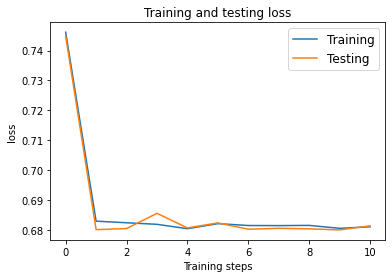

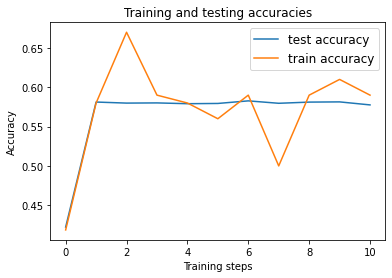

In [10]:
with tf.device('/device:cpu:0'):
  ### Hyperparameters
  num_epochs = 10
  learning_rate = 0.01
  train_size = 70000
  test_size = 10000
  units = 32
  batch_size = 100

  ds = prepare_data(ds)
  train_dataset = ds.take(train_size)
  ds.skip(train_size)
  test_dataset = ds.take(test_size)

  # Initialize the model.
  model = LSTM_Model(units)

  # Initialize the loss: binary cross entropy
  b_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()

  #initializ optimizer
  opt = tf.keras.optimizers.Adam(learning_rate)
  
  # Initialize lists for later visualization.
  train_losses = []
  test_losses = []

  train_accuracies = []
  test_accuracies = []

  #testing once before we begin
  test_loss, test_accuracy = test(model, test_dataset, b_cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  #check how model performs on train data once before we begin
  train_loss, train_accuracy = test(model, train_dataset, b_cross_entropy_loss)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)


  # We train for num_epochs epochs
  for epoch in range(num_epochs):

      #training (and checking in with training)
      epoch_loss_agg = []
      epoch_acc_agg = []
      for input,target in train_dataset:
          train_loss, train_accuracy = train_step(model, input, target, b_cross_entropy_loss, opt)
          epoch_loss_agg.append(train_loss)

          #track training loss
      train_losses.append(tf.reduce_mean(epoch_loss_agg))
      # tracking train accuracy
      train_accuracies.append(tf.reduce_mean(train_accuracy))

      #testing, so we can track accuracy and test loss
      test_loss, test_accuracy = test(model, test_dataset, b_cross_entropy_loss)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)

  visualization(train_losses, test_losses, train_accuracies, test_accuracies)